In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import svm
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load data

In [3]:
# Load the line-delimited JSON file directly into a DataFrame

#data_path = 'transactions.txt'

# Using pandas to read the raw file
# df = pd.read_json(data_path, lines=True)

# Save the DataFrame as a CSV file
# df.to_csv('transactions_simplified.csv', index=False)

# Path of the CSV file
csv_file_path = 'transactions_simplified.csv'

# Read the CSV file into a DataFrame
df_transactions = pd.read_csv(csv_file_path)

df_transactions.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [149]:
# Display the number of samples (rows) and features (columns)
num_samples, num_features = df_transactions.shape
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

Number of samples: 786363
Number of features: 29


In [51]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  float64
 10  posConditionCode          785954 non-null  float64
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [52]:
# Check the number of null values in each column
df_transactions.isnull().sum()

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

In [150]:
# Drop null columns
df_transactions.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis=1, inplace=True)

In [151]:
# Display the number of samples (rows) and features (columns) after dropping null columns
num_samples, num_features = df_transactions.shape
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

Number of samples: 786363
Number of features: 23


In [46]:
df_transactions.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
accountNumber,786363.0,5.372326e+08,2.554211e+08,1.000881e+08,3.301333e+08,5.074561e+08,7.676200e+08,9.993896e+08
customerId,786363.0,5.372326e+08,2.554211e+08,1.000881e+08,3.301333e+08,5.074561e+08,7.676200e+08,9.993896e+08
creditLimit,786363.0,1.075946e+04,1.163617e+04,2.500000e+02,5.000000e+03,7.500000e+03,1.500000e+04,5.000000e+04
availableMoney,786363.0,6.250725e+03,8.880784e+03,-1.005630e+03,1.077420e+03,3.184860e+03,7.500000e+03,5.000000e+04
transactionAmount,786363.0,1.369858e+02,1.477256e+02,0.000000e+00,3.365000e+01,8.790000e+01,1.914800e+02,2.011540e+03
posEntryMode,782309.0,9.049943e+00,1.677413e+01,2.000000e+00,2.000000e+00,5.000000e+00,9.000000e+00,9.000000e+01
posConditionCode,785954.0,3.271980e+00,9.809023e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.900000e+01
cardCVV,786363.0,5.444673e+02,2.615242e+02,1.000000e+02,3.100000e+02,5.350000e+02,7.850000e+02,9.980000e+02
enteredCVV,786363.0,5.441839e+02,2.615513e+02,0.000000e+00,3.100000e+02,5.350000e+02,7.850000e+02,9.980000e+02
cardLast4Digits,786363.0,4.757418e+03,2.996584e+03,0.000000e+00,2.178000e+03,4.733000e+03,7.338000e+03,9.998000e+03


In [73]:
df_transactions.transactionAmount.describe()

count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64

 I checked the statistics description of transaction amounts. In total we have 786363 transaction (number of rows), Maximum transaction amount which iss 2011 dollar, Average of transaction amount which is 136.98, the standard deviation of transaction amount that is 147.72.

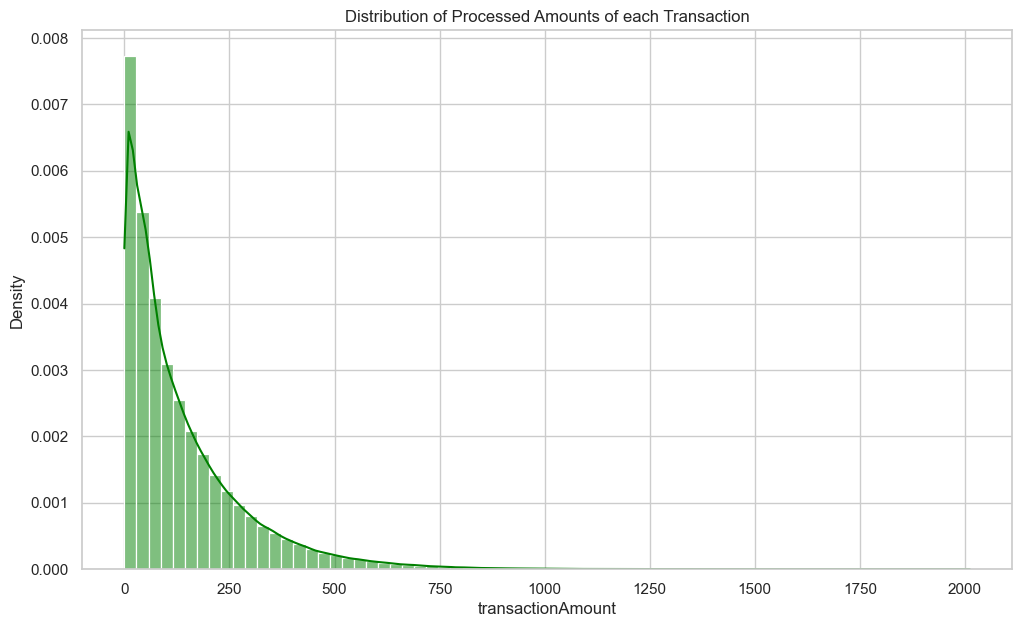

In [79]:
fig = plt.subplots(1,1,figsize=(12,7))
sns.histplot(df_transactions.transactionAmount, bins=70, stat='density', color='green',kde=True).set_title("Distribution of Processed Amounts of each Transaction")
plt.show()

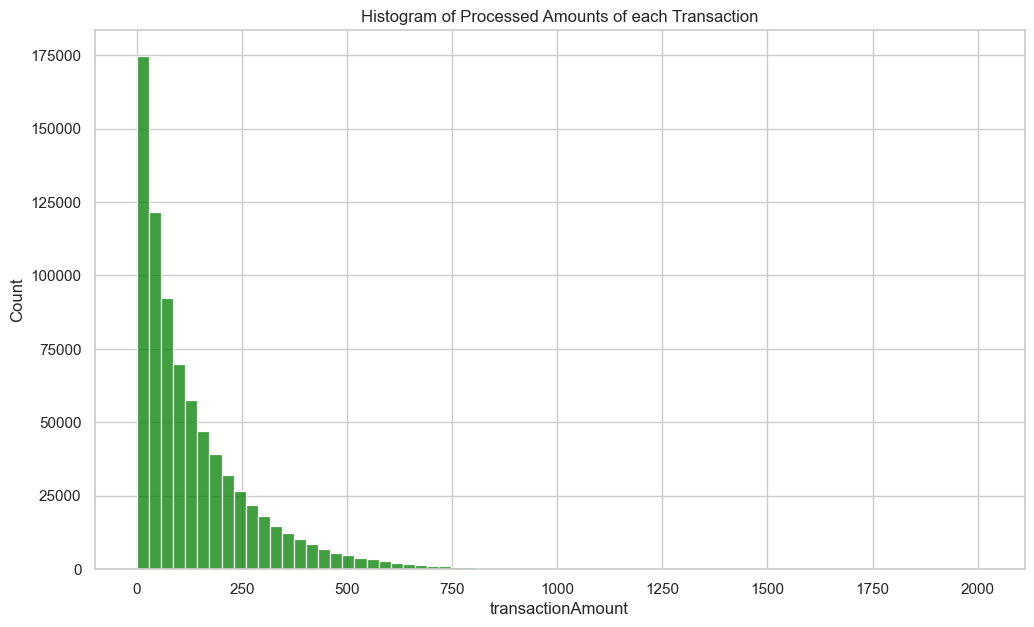

In [80]:
fig = plt.subplots(1,1,figsize=(12,7))
sns.histplot(df_transactions.transactionAmount, bins=70,color='green').set_title("Histogram of Processed Amounts of each Transaction")
plt.show() 

I plotted the transactions amounts by applying histogram for both density and count. This shows that there is right skewed (positive skewness) distribution. Avg. of transaction amounts (136.98) is much higher than median of transaction amounts (87.90)


The transaction amounts are heavily right-skewed. Most of the transactions are at lower amounts,
with a sharp decline as the amounts increase.
The majority of transactions between $0 and $200. This is a common trend for financial transactions.

The plot shows a long tail of larger transactions.
Higher-value transactions (e.g., $500-$2000) occur much less frequently.


The density peak is at a very low value, indicating that the most common transactions
are small.

Given the high concentration of transactions at smaller amounts,
it is possible that fraudsters target smaller transactions to remain under the radar. 
Analyzing fraudulent vs. non-fraudulent transactions in this range could reveal important insights.
Focus on Higher-Value Transactions:

While fewer transactions occur in the higher ranges, they are likely more impactful.
Fraudulent activity might be easier to detect here because of increased attention to
large-value transactions. A separate analysis of large transactions might reveal more
specific patterns of fraud.

Bacause of that I will consider: Break down this same plot into two categories: fraudulent and non-fraudulent transactions to see the pattern.


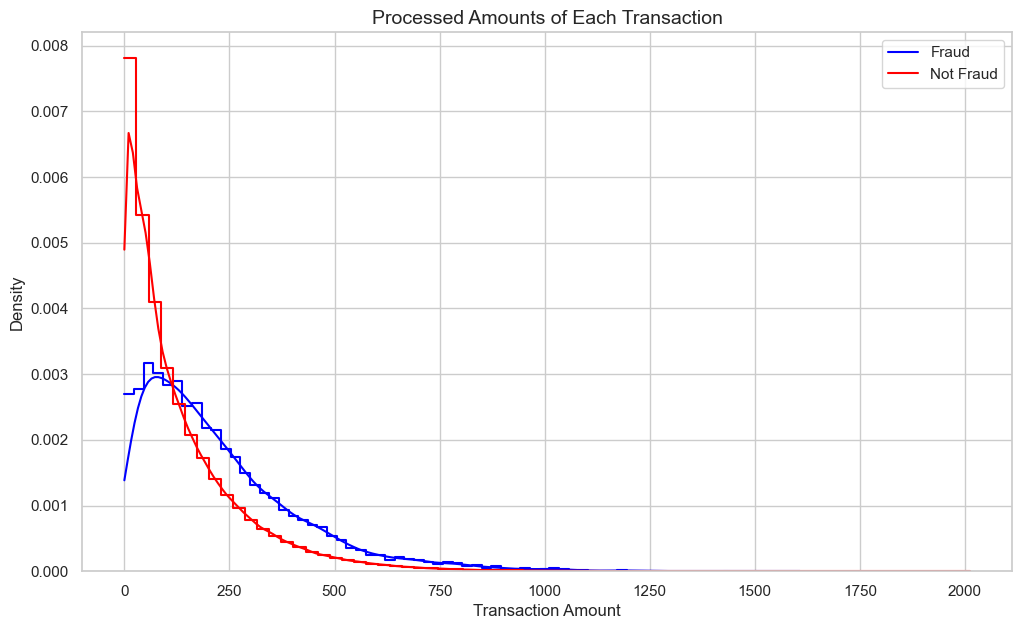

In [66]:
# compare fraud and non fraud transctions amount 
plt.figure(figsize=(12, 7))

#Fraud transactions
sns.histplot(df_transactions[df_transactions.isFraud == True]['transactionAmount'], 
             bins=70, color='blue', label='Fraud', kde=True, stat='density', element='step', fill=False)

#Not Fraud transactions
sns.histplot(df_transactions[df_transactions.isFraud == False]['transactionAmount'], 
             bins=70, color='red', label='Not Fraud', kde=True, stat='density', element='step', fill=False)

plt.title("Processed Amounts of Each Transaction")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend()
plt.show()

###### Transaction Amount Distribution:

The majority of both fraudulent and non-fraudulent transactions have lower amounts
Both fraud and non-fraud transactions exhibit a right-skewed distribution,
indicating that a small number of transactions involve higher amounts.

However, the mean of fraud curve is more than non- fraud one. Indicating that the fraud tranactions cover more amount than the regular ones.

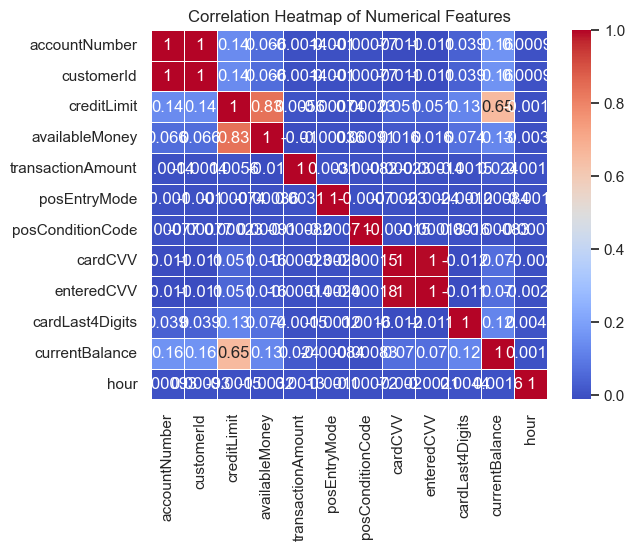

In [76]:
# Selecting only the numeric columns
numeric_df = df_transactions.select_dtypes(include=[np.number])

# Calculating the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

###### A heat map of the numerical features, indicating the linear relationship they might have. The closer values to 1 or -1, the more linear relationship they have.

### Anlayzing a few of the the catogrical features

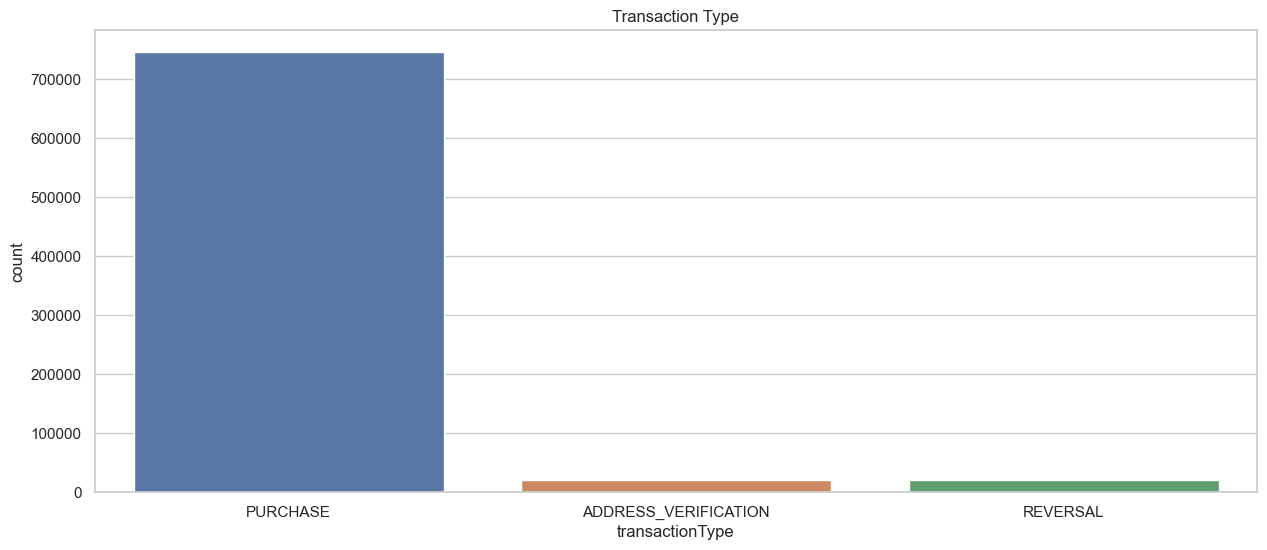

In [93]:
# Plotting transactionType
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.countplot(x="transactionType", data=df_transactions, ax=ax).set_title("Transaction Type")
plt.show()

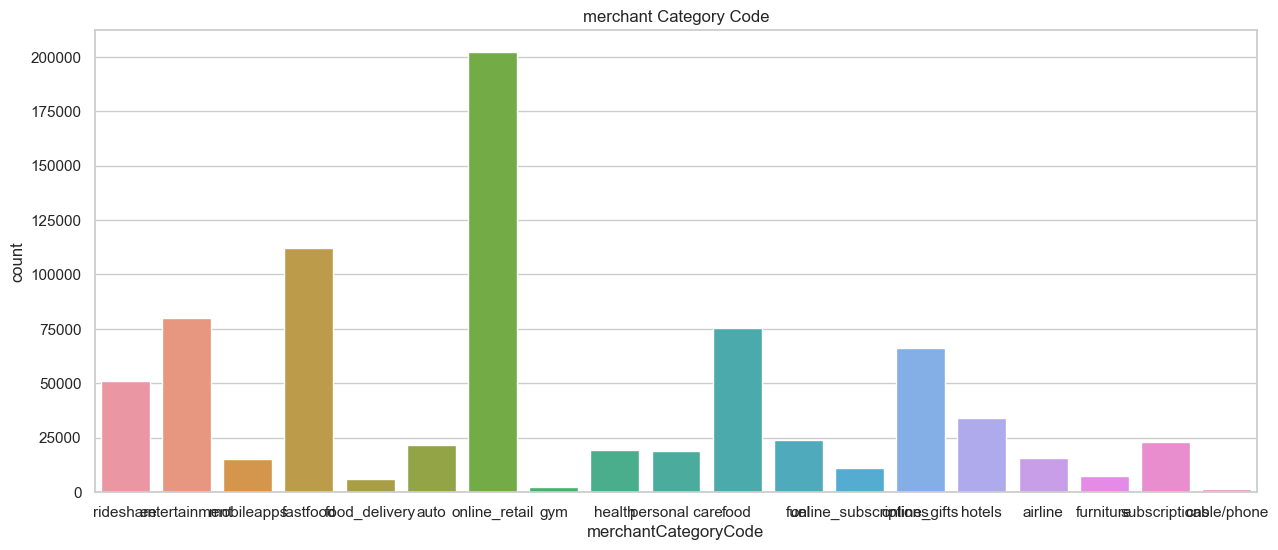

In [100]:
# Plotting merchantCategoryCode
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.countplot(x="merchantCategoryCode", data=df_transactions, ax=ax).set_title("merchant Category Code")
plt.show()

 Apparently, Online_retail category is the most popular one.

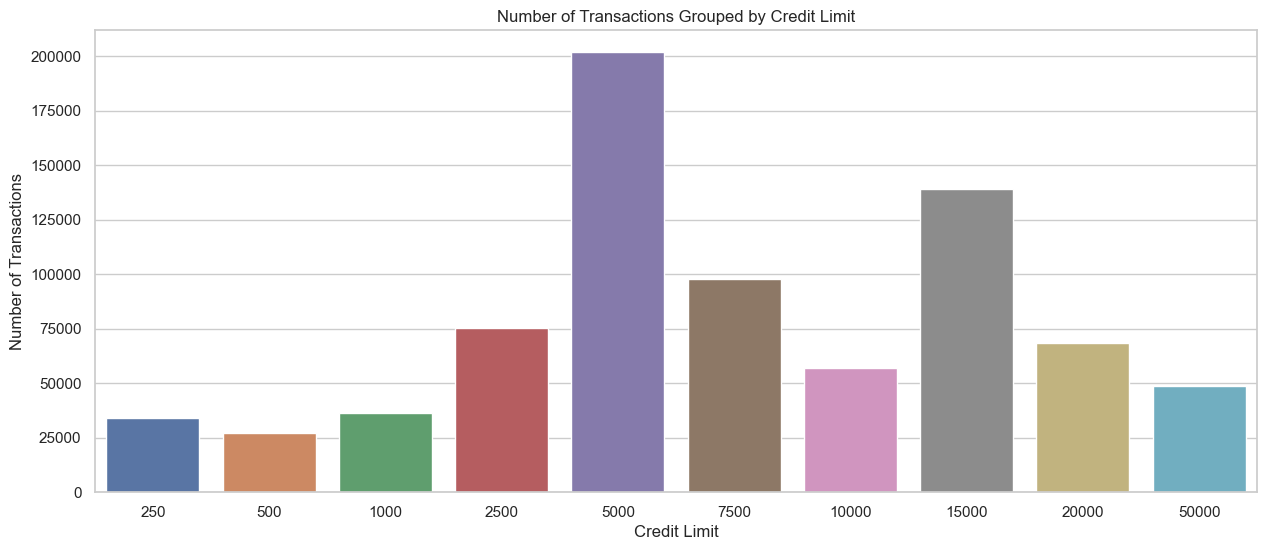

In [95]:
# Group the transactions by 'creditLimit' and count the number of transactions
credit_limit_counts = df_transactions.groupby('creditLimit').size().reset_index(name='count')

plt.figure(figsize=(15, 6))
sns.barplot(x='creditLimit', y='count', data=credit_limit_counts)

plt.title("Number of Transactions Grouped by Credit Limit")
plt.xlabel("Credit Limit")
plt.ylabel("Number of Transactions")
plt.show()


As it is shown in the plot, customers with the credit amount of $5K do the most of the transactions.

# Data Wrangling - Duplicate Transactions

## i) Reversal Transaction 

In [152]:
reversal = df_transactions[df_transactions['transactionType']=='REVERSAL']
reversal

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
39,574788567,574788567,2500,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,9.0,...,2015-10-13,2015-10-13,206,206,8522,REVERSAL,299.02,True,False,False
73,574788567,574788567,2500,2432.72,2016-10-07T10:23:57,3.87,Eazy Repair,US,US,5.0,...,2015-10-13,2015-10-13,579,579,4219,REVERSAL,67.28,True,False,False
101,924729945,924729945,50000,49831.43,2016-10-19T14:01:45,168.57,discount.com,US,US,5.0,...,2014-07-25,2014-07-25,205,265,9459,REVERSAL,168.57,False,False,False
133,984504651,984504651,50000,46367.41,2016-01-16T09:53:15,450.74,Planet Fitness #849960,US,US,5.0,...,2015-07-27,2015-07-27,640,640,8332,REVERSAL,3632.59,False,False,False
156,984504651,984504651,50000,41909.30,2016-01-25T20:39:15,81.73,AMC #724446,US,US,9.0,...,2015-07-27,2015-07-27,640,640,8332,REVERSAL,8090.70,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786106,899818521,899818521,2500,968.33,2016-09-29T02:04:32,10.05,cheapfast.com,US,US,2.0,...,2013-06-15,2013-06-15,421,421,3424,REVERSAL,1531.67,False,False,False
786120,638498773,638498773,10000,9798.21,2016-01-01T19:48:03,201.79,KFC #928167,US,US,5.0,...,2014-11-17,2014-11-17,175,175,321,REVERSAL,201.79,True,False,False
786219,638498773,638498773,10000,5331.33,2016-11-03T04:23:26,86.14,Dunkin' Donuts #396342,US,US,5.0,...,2014-11-17,2014-11-17,387,387,4635,REVERSAL,4668.67,True,False,False
786225,638498773,638498773,10000,4393.10,2016-11-06T22:54:25,49.39,Shake Shack #118502,US,US,5.0,...,2014-11-17,2014-11-17,387,387,4635,REVERSAL,5606.90,True,False,False


#### A total number of 20303 transctions belongs to reversal.

In [153]:
# checking if all the reversal transactions equal amounnt after the purchase
df_reversal = df_transactions
df_reversal['Date'] = df_reversal['transactionDateTime'].str.split('T').str[0]
df_reversal['Time'] = df_reversal['transactionDateTime'].str.split('T').str[1]
df_reversal['Timestamp'] = pd.to_datetime(df_reversal['Date'] + ' ' + df_reversal['Time'])
df_reversal = df_reversal.sort_values(by=['customerId', 'merchantName', 'Timestamp']).reset_index(drop=True)


revers_idx = df_reversal[df_reversal['transactionType']=='REVERSAL'].index.values.astype(int)
revers = df_reversal.iloc[revers_idx]

# finding the purchase index of the correspond reverse
purchase_idx = revers_idx - 1
purchase = df_reversal.iloc[purchase_idx]

In [154]:
reversal_data = pd.concat([
    pd.Series(purchase_idx, name='Purchase_Index'),
    pd.Series(purchase['transactionAmount'].values, name='Purchase_Amount'),
    pd.Series(purchase['customerId'].values, name='Purchase_customer_Id'),
    pd.Series(revers_idx, name='Reversal_Index'),
    pd.Series(revers['transactionAmount'].values, name='Reversal_Amount'),
    pd.Series(revers['customerId'].values, name='Reversal_customer_Id')], axis=1)

reversal_data.head(10)

,Purchase_Index,Purchase_Amount,Purchase_customer_Id,Reversal_Index,Reversal_Amount,Reversal_customer_Id
0,12,22.32,100088067,13,22.32,100088067
1,125,43.74,100328049,126,43.74,100328049
2,141,284.97,100328049,142,284.97,100328049
3,267,93.67,100737756,268,93.67,100737756
4,283,501.29,100737756,284,501.29,100737756
5,295,522.20,100737756,296,522.20,100737756
6,548,0.00,101376441,549,0.00,101376441
7,574,96.63,101376441,575,96.63,101376441
8,608,46.27,101380713,609,0.00,101380713
9,682,7.08,101380713,683,5.03,101380713


In [155]:
reversal_data.shape

(20303, 6)

In [83]:
matching_customers = reversal_data['Purchase_customer_Id'] == reversal_data['Reversal_customer_Id']

# Check how many rows have matching customer IDs
if matching_customers.all():
    print("All purchase and reversal customer IDs match.")
else:
    mismatch_count = len(reversal_data) - matching_customers.sum()
    print("There are some mismatches where the customer IDs don't match.")

All purchase and reversal customer IDs match.


In [84]:
# Check if Purchase_Amount and Reversal_Amount are the same for all rows
matching_amounts = reversal_data['Purchase_Amount'] == reversal_data['Reversal_Amount']

# Check how many rows have matching amounts
if matching_amounts.all():
    print("All purchase and reversal amounts match.")
else:
    # Correct way to calculate mismatches
    mismatch_count = len(reversal_data) - matching_amounts.sum()
    print(f"There are {mismatch_count} mismatches where the purchase and reversal amounts don't match.")

# Optionally, display the rows where amounts don't match
mismatched_rows = reversal_data[~matching_amounts]
print("Rows with mismatched amounts:")
print(mismatched_rows)

There are 7287 mismatches where the purchase and reversal amounts don't match.
Rows with mismatched amounts:
       Purchase_Index  Purchase_Amount  Purchase_customer_Id  Reversal_Index  \
8                 608            46.27             101380713             609   
9                 682             7.08             101380713             683   
14                865           128.21             101661970             866   
15               1069            50.83             101738384            1070   
16               1163             0.00             101738384            1164   
...               ...              ...                   ...             ...   
20287          785787           172.33             999086814          785788   
20288          785788           159.82             999086814          785789   
20290          785818            82.21             999086814          785819   
20292          786020           187.94             999257059          786021   
20293      

In [85]:
print( f"The whole reserval amount by the customers:", reversal_data['Reversal_Amount'].sum().round(1))

The whole reserval amount by the customers: 2821792.5


In [86]:
print( f"The whole pourchase amount by the customers who has reversal later:", reversal_data['Purchase_Amount'].sum().round(1))

The whole pourchase amount by the customers who has reversal later: 2992274.8


## ii) Multi_Swipe Transctions

In [174]:
df_multi_swipe = df_transactions
df_multi_swipe['transaction_time'] = df_multi_swipe['transactionDateTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))

# Calculate the time difference between consecutive transactions
df_multi_swipe['difference'] = df_multi_swipe['transaction_time'] - df_multi_swipe['transaction_time'].shift(1)

# Check if the account numbers are the same for consecutive transactions
df_multi_swipe['account_check'] = df_multi_swipe['accountNumber'] == df_multi_swipe['accountNumber'].shift(1)

# Convert the time difference to seconds
df_multi_swipe['difference_int'] = df_multi_swipe['difference'].dt.total_seconds()

# Threshold to consider a multi-swipe transaction
threshold_seconds = 180

# Identify multi-swipe transactions (exclude the first transaction for the same account considering threshold)
multi_swipe_transactions = df_multi_swipe[(df_multi_swipe['account_check']) & (df_multi_swipe['difference_int'] < threshold_seconds)]

num_multi_swipe_transactions = len(multi_swipe_transactions)

total_multi_swipe_amount = multi_swipe_transactions['transactionAmount'].sum()

multi_swipe_transactions.head()


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardPresent,expirationDateKeyInMatch,isFraud,Date,Time,Timestamp,transaction_time,difference,account_check,difference_int
39,574788567,574788567,2500,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,9.0,...,True,False,False,2016-05-24,01:38:03,2016-05-24 01:38:03,2016-05-24 01:38:03,0 days 00:02:30,True,150.0
133,984504651,984504651,50000,46367.41,2016-01-16T09:53:15,450.74,Planet Fitness #849960,US,US,5.0,...,False,False,False,2016-01-16,09:53:15,2016-01-16 09:53:15,2016-01-16 09:53:15,0 days 00:00:45,True,45.0
200,984504651,984504651,50000,36452.49,2016-02-12T05:10:49,34.92,Golds Gym #747443,US,US,9.0,...,False,False,False,2016-02-12,05:10:49,2016-02-12 05:10:49,2016-02-12 05:10:49,0 days 00:02:26,True,146.0
263,984504651,984504651,50000,26680.99,2016-03-12T06:34:29,118.52,AMC #706324,US,US,2.0,...,True,False,False,2016-03-12,06:34:29,2016-03-12 06:34:29,2016-03-12 06:34:29,0 days 00:00:16,True,16.0
264,984504651,984504651,50000,26562.47,2016-03-12T06:36:41,118.52,AMC #706324,US,US,2.0,...,True,False,False,2016-03-12,06:36:41,2016-03-12 06:36:41,2016-03-12 06:36:41,0 days 00:02:12,True,132.0


In [175]:
print(f"Number of multi-swipe transactions: {num_multi_swipe_transactions}")

Number of multi-swipe transactions: 25819


In [176]:
print(f"Total amount of multi-swipe transactions: {total_multi_swipe_amount:.2f}")

Total amount of multi-swipe transactions: 3680948.63


In [100]:
# Get indices for reversal and multi-swipe transactions
reversal_indices = reversal_data.index
multi_swipe_indices = multi_swipe_transactions.index

# Combine indices and drop them from the original DataFrame
all_duplicate_indices = reversal_indices.union(multi_swipe_indices)

# Remove the duplicate transactions from the main DataFrame
df_cleaned = df_transactions.drop(all_duplicate_indices)

# Verify the cleaned DataFrame
print(f"Original DataFrame size: {len(df_transactions)}")
print(f"Cleaned DataFrame size: {len(df_cleaned)}")
print(f"Number of rows removed: {len(df_transactions) - len(df_cleaned)}")

Original DataFrame size: 786363
Cleaned DataFrame size: 740682
Number of rows removed: 45681


Now that we have the reversal and multi-swipe subsets, we can perform a more detailed analysis on these specific transaction types to explore their relationship with fraud.Considering the fact that reversal and multi-swipe transactions have unique patterns, analyzing their behavior in relation to fraud activities may show valuable insights and help identify potential risks.

Text(0.5, 1.0, 'Fraudul Transaction for reversed')

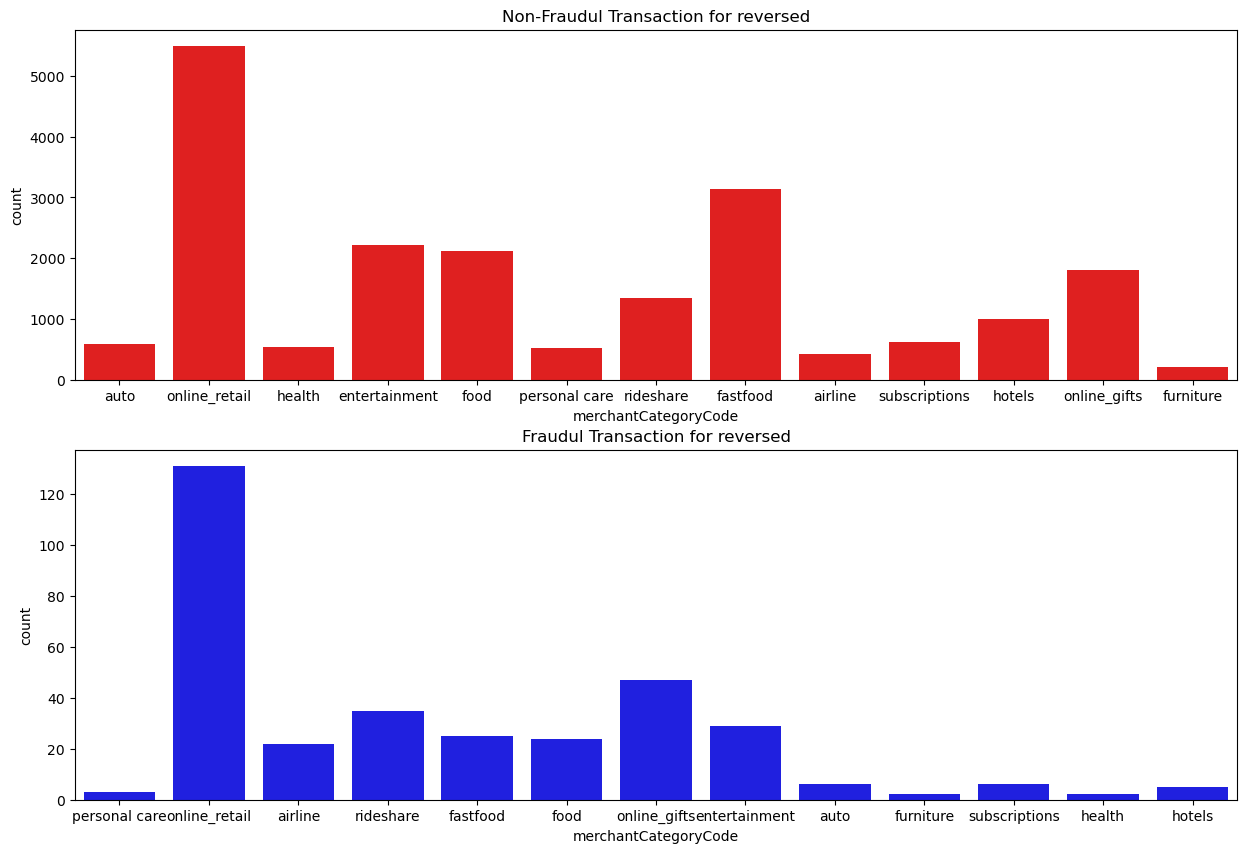

In [165]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

sns.countplot(
    x="merchantCategoryCode",
    data=reversal[reversal['isFraud'] == False], 
    color="red",  
    ax=axes[0])
axes[0].set_title("Non-Fraudul Transaction for reversed")


sns.countplot(
    x="merchantCategoryCode",
    data = reversal[reversal['isFraud'] == True], 
    color="blue", 
    ax=axes[1])
axes[1].set_title("Fraudul Transaction for reversed")

The comparison shows that "online_retail" has the highest count of both non-fraudulent and fraudulent reversed transactions, but fraudulent transactions also have a more diverse spread across categories like "rideshare," "entertainment," and "online_gifts." This suggests that certain merchant categories might be more prone to fraudulent activities in reversed transactions

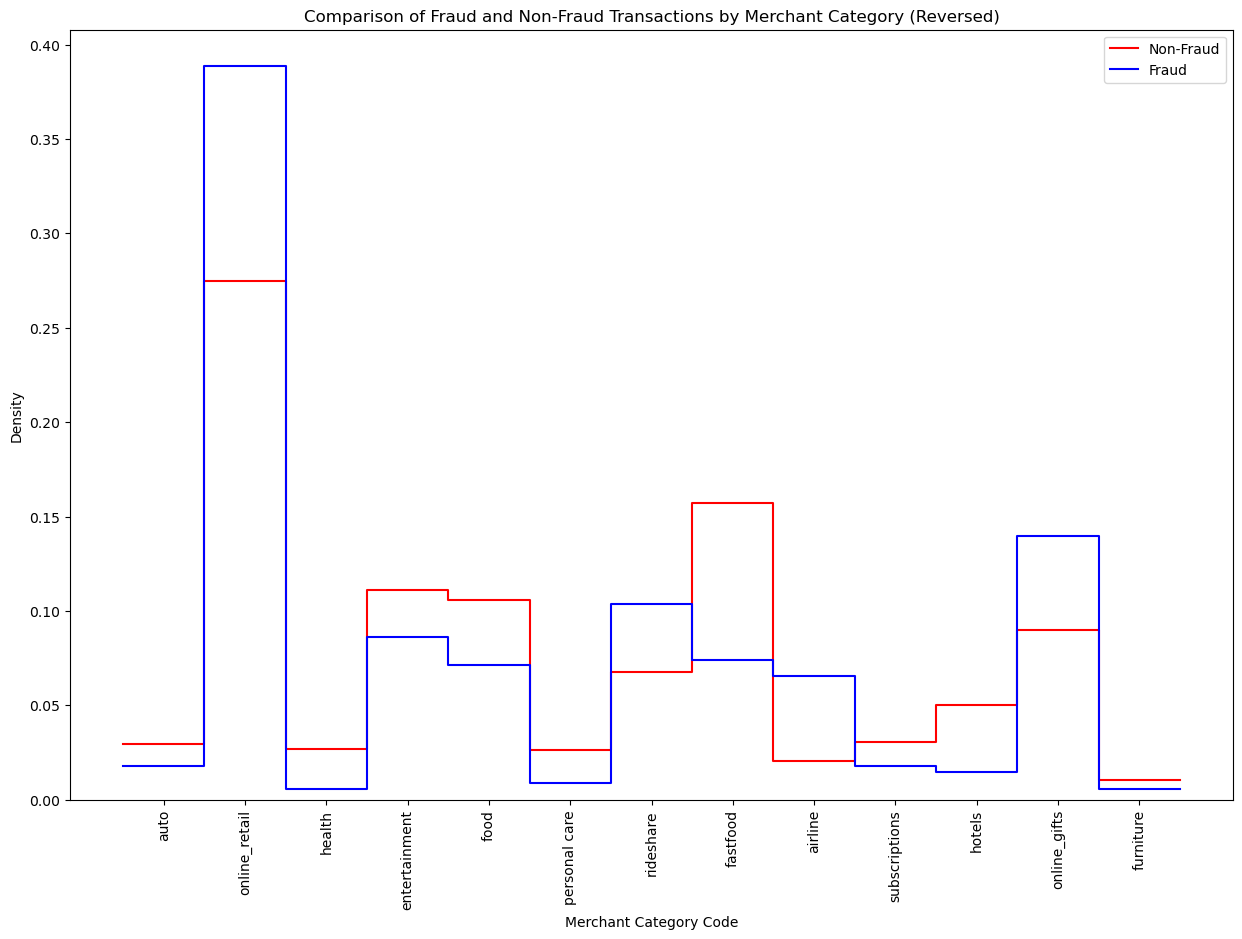

In [166]:
plt.figure(figsize=(15, 10))

#Non-Fraudulent Transactions for Reversed
sns.histplot(
    reversal[reversal['isFraud'] == False]['merchantCategoryCode'], 
    color='red', label='Non-Fraud', stat='density', element='step', fill=False
)

#Fraudulent Transactions for Reversed
sns.histplot(
    reversal[reversal['isFraud'] == True]['merchantCategoryCode'], 
    color='blue', label='Fraud', stat='density', element='step', fill=False
)

plt.title("Comparison of Fraud and Non-Fraud Transactions by Merchant Category (Reversed)")
plt.xlabel("Merchant Category Code")
plt.ylabel("Density")
plt.xticks(rotation=90) 
plt.legend()
plt.show()

The plot suggests that some merchant categories, such as "online_retail" and "fastfood," have a higher density of fraudulent transactions compared to non-fraudulent ones, indicating potential areas of concern for fraud risk.

C:\Users\fsalboukh\AppData\Local\Temp\ipykernel_4904\1945209280.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\fsalboukh\AppData\Local\Temp\ipykernel_4904\1945209280.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Fraudul Transaction for reversed')

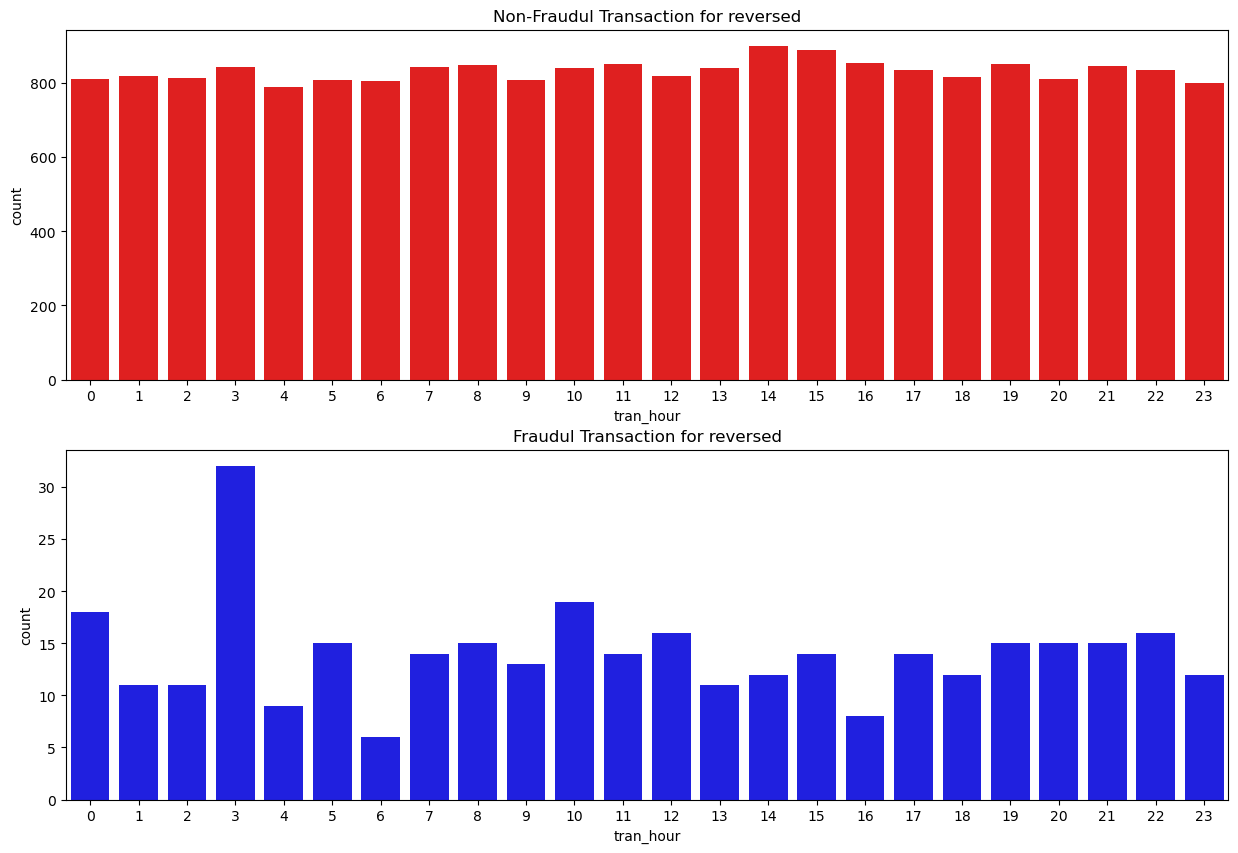

In [171]:
reversal['transaction_time'] = reversal['transactionDateTime'].apply(lambda x:datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
reversal['transaction_hour'] = reversal['transaction_time'].dt.hour


fig, axes = plt.subplots(2, 1, figsize=(15, 10))

sns.countplot(
    x="transaction_hour",
    data=reversal[reversal['isFraud'] == False], 
    color="red",  
    ax=axes[0])
axes[0].set_title("Non-Fraud Transaction for reversed")


sns.countplot(
    x="transaction_hour",
    data = reversal[reversal['isFraud'] == True], 
    color="blue", 
    ax=axes[1])
axes[1].set_title("Fraud Transaction for reversed")


The pick hour of reversal transactions for non-fraud ones is around 14 (2 pm) and for fraud ones is around 3 am.

Text(0.5, 1.0, 'Fraud Transaction for multi_swipe')

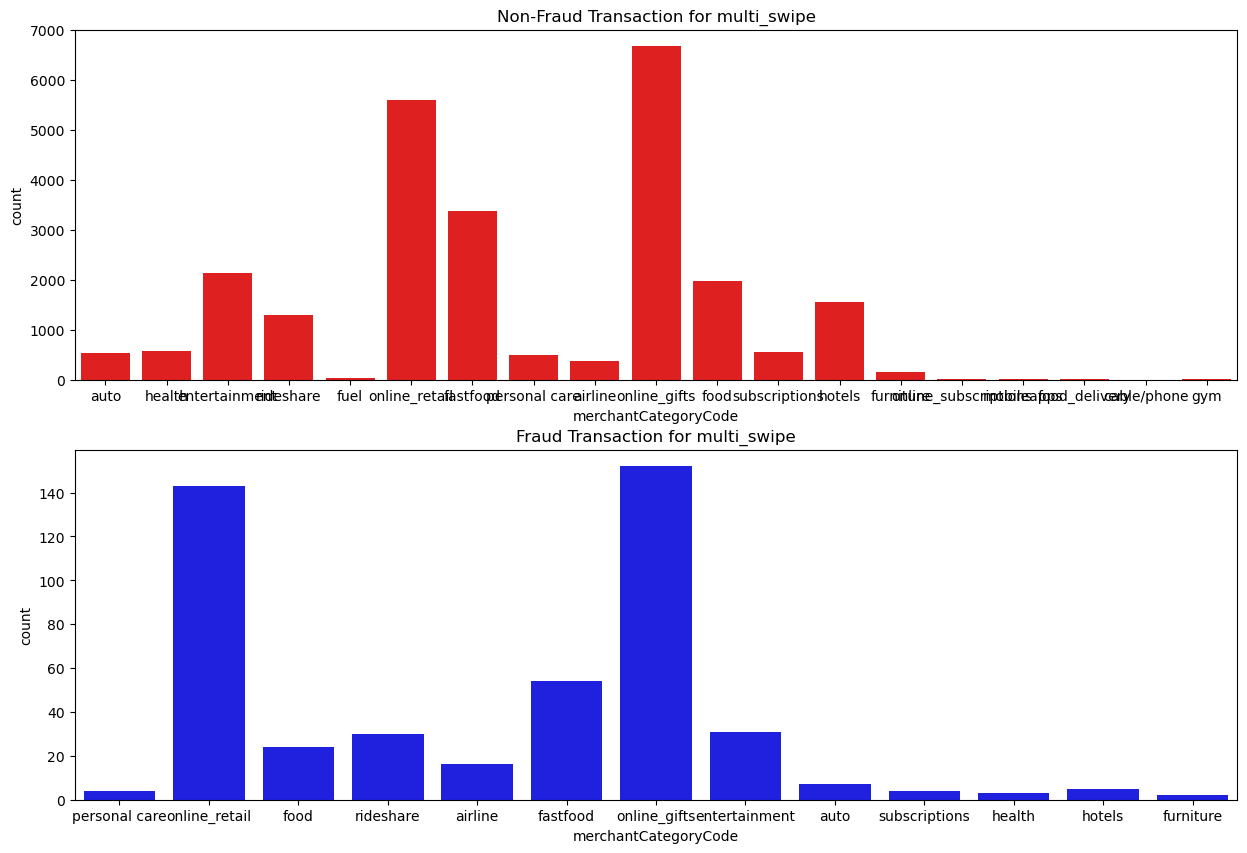

In [179]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

sns.countplot(
    x="merchantCategoryCode",
    data=multi_swipe_transactions[multi_swipe_transactions['isFraud'] == False], 
    color="red",  
    ax=axes[0])
axes[0].set_title("Non-Fraud Transaction for multi_swipe")


sns.countplot(
    x="merchantCategoryCode",
    data = multi_swipe_transactions[multi_swipe_transactions['isFraud'] == True], 
    color="blue", 
    ax=axes[1])
axes[1].set_title("Fraud Transaction for multi_swipe")

The comparison shows that "online_gift" and "online_retail"  have the highest count of both non-fraudulent and fraudulent multi swipe transactions.

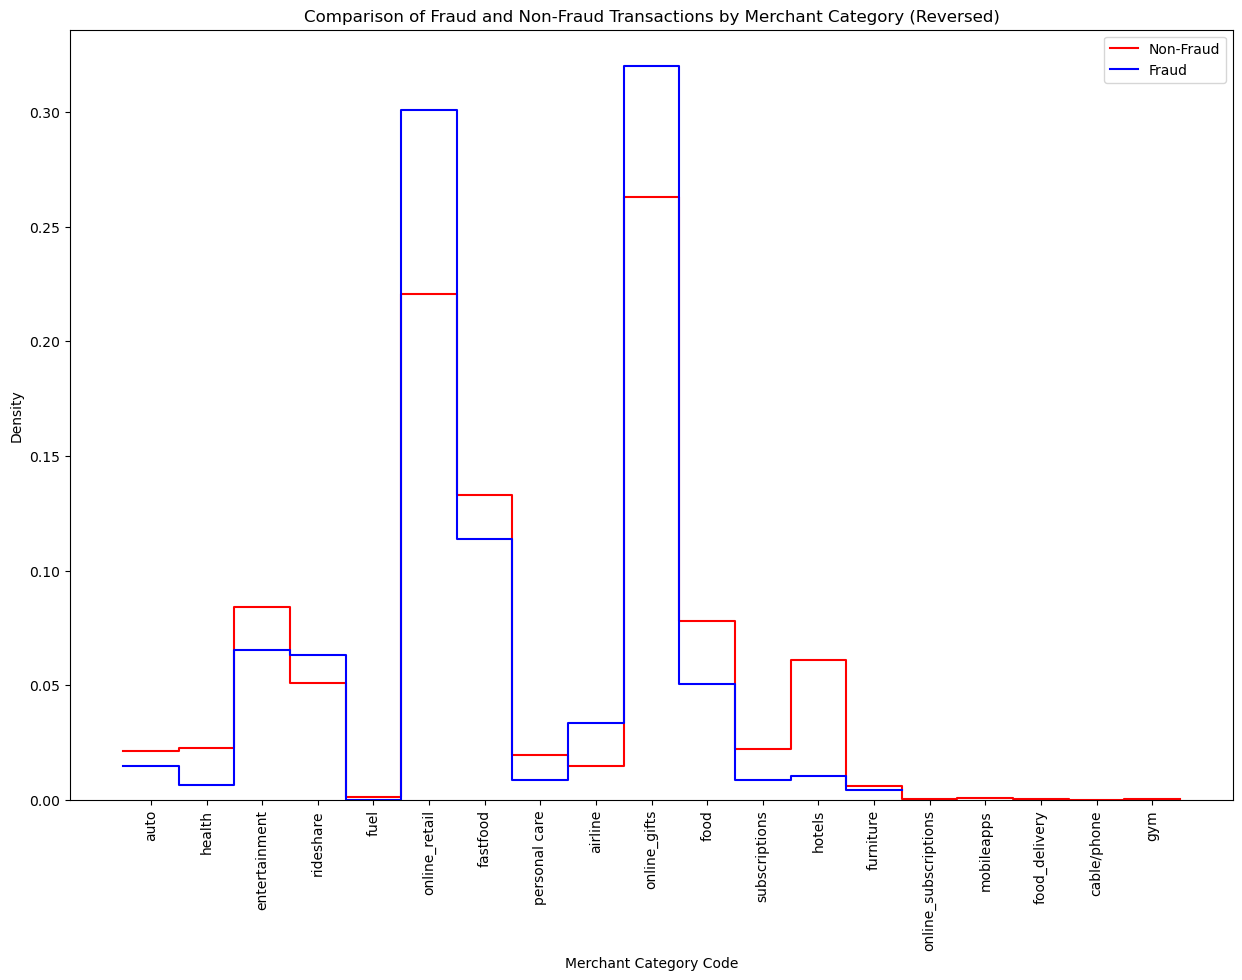

In [180]:
plt.figure(figsize=(15, 10))

#Non-Fraudulent Transactions for Reversed
sns.histplot(
    multi_swipe_transactions[multi_swipe_transactions['isFraud'] == False]['merchantCategoryCode'], 
    color='red', label='Non-Fraud', stat='density', element='step', fill=False
)

#Fraudulent Transactions for Reversed
sns.histplot(
    multi_swipe_transactions[multi_swipe_transactions['isFraud'] == True]['merchantCategoryCode'], 
    color='blue', label='Fraud', stat='density', element='step', fill=False
)

plt.title("Comparison of Fraud and Non-Fraud Multi Swipe Transactions by Merchant Category")
plt.xlabel("Merchant Category Code")
plt.ylabel("Density")
plt.xticks(rotation=90) 
plt.legend()
plt.show()

This plot indicates that fraudulent transactions (blue) have a higher density in categories like "online_retail" and "food" compared to non-fraudulent transactions (red). However, "online_retail" seems to dominate both fraudulent and non-fraudulent transactions.

C:\Users\fsalboukh\AppData\Local\Temp\ipykernel_4904\1767820026.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Fraud Transaction for multi_swipe')

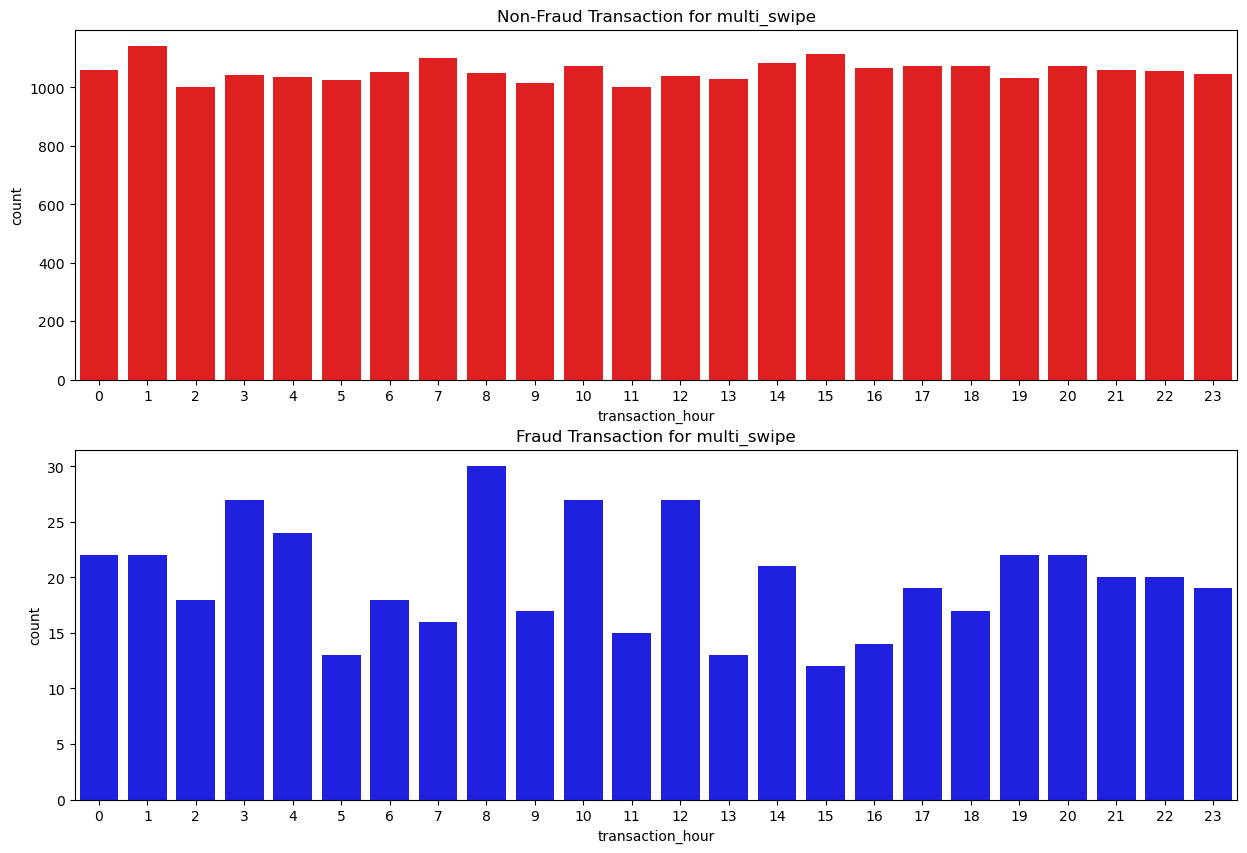

In [178]:
multi_swipe_transactions['transaction_hour'] = multi_swipe_transactions['transaction_time'].dt.hour


fig, axes = plt.subplots(2, 1, figsize=(15, 10))

sns.countplot(
    x="transaction_hour",
    data=multi_swipe_transactions[multi_swipe_transactions['isFraud'] == False], 
    color="red",  
    ax=axes[0])
axes[0].set_title("Non-Fraud Transaction for multi_swipe")


sns.countplot(
    x="transaction_hour",
    data = multi_swipe_transactions[multi_swipe_transactions['isFraud'] == True], 
    color="blue", 
    ax=axes[1])
axes[1].set_title("Fraud Transaction for multi_swipe")

The pick hour of multi swipe transactions for non-fraud ones is around 1 am and for fraud ones is around 8 am.

After these detailed analysis, we can be more careful obout potential categories (online gift and online retail) and time that most of the fraud tranactions (at midnight and early morining) are happening in the frame of reversed or multi swipe tranactions.

# Modelling

Each of the transactions in the dataset has a field called isFraud. I build a predictive model to determine whether a given transaction will be fraudulent or not. 


In [ ]:
# converting Date and Time columns to standard format
df_cleaned['transaction_time'] = df_cleaned['transactionDateTime'].apply(lambda x:datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
df_cleaned['current_expire_date'] = df_cleaned['currentExpDate'].apply(lambda x:datetime.strptime(x, '%m/%Y'))
#df_cleaned['Open_Date'] = df_transactions['accountOpenDate'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
#df_cleaned['Last_AddressChange_date'] = df_transactions['dateOfLastAddressChange'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

df_cleaned['tran_yr'] = df_cleaned['transaction_time'].dt.year
df_cleaned['tranaction_hour'] = df_cleaned['transaction_time'].dt.hour
df_cleaned['tran_min'] = df_cleaned['transaction_time'].dt.minute
df_cleaned['Expyear'] = df_cleaned['current_expire_date'].dt.year 
df_cleaned['Expmonth'] = df_cleaned['current_expire_date'].dt.month 


In [102]:
df_cleaned.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardPresent,expirationDateKeyInMatch,isFraud,transaction_time,current_expire_date,tran_yr,tranaction_hour,tran_min,Expyear,Expmonth
20303,353223945,353223945,5000,1510.20,2016-11-01T10:45:57,29.01,Uber,US,US,5.0,...,False,False,False,2016-11-01 10:45:57,2019-12-01,2016,10,45,2019,12
20304,353223945,353223945,5000,1481.19,2016-11-06T03:19:17,107.63,Sprint PCS #619576,US,US,9.0,...,True,False,False,2016-11-06 03:19:17,2029-07-01,2016,3,19,2029,7
20305,353223945,353223945,5000,1373.56,2016-11-07T21:29:37,10.69,hulu.com,US,US,80.0,...,False,False,False,2016-11-07 21:29:37,2030-05-01,2016,21,29,2030,5
20306,353223945,353223945,5000,1362.87,2016-11-22T14:19:09,123.80,Burger King #627282,US,US,9.0,...,True,False,False,2016-11-22 14:19:09,2020-09-01,2016,14,19,2020,9
20307,353223945,353223945,5000,1264.07,2016-12-01T05:38:32,77.91,Lyft,US,US,90.0,...,False,False,False,2016-12-01 05:38:32,2021-04-01,2016,5,38,2021,4


In [103]:
# categorical columns that need encoding
categorical_columns = ['acqCountry', 'merchantCountryCode', 'merchantCategoryCode', 'transactionType']

# Frequency Encoding
for col in categorical_columns:
    frequency_encoding = df_cleaned[col].value_counts(normalize=True)
    df_cleaned[col] = df_cleaned[col].map(frequency_encoding)

df_cleaned.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,cardPresent,expirationDateKeyInMatch,isFraud,transaction_time,current_expire_date,tran_yr,tranaction_hour,tran_min,Expyear,Expmonth
20303,353223945,353223945,5000,1510.20,2016-11-01T10:45:57,29.01,Uber,0.990973,0.990975,5.0,...,False,False,False,2016-11-01 10:45:57,2019-12-01,2016,10,45,2019,12
20304,353223945,353223945,5000,1481.19,2016-11-06T03:19:17,107.63,Sprint PCS #619576,0.990973,0.990975,9.0,...,True,False,False,2016-11-06 03:19:17,2029-07-01,2016,3,19,2029,7
20305,353223945,353223945,5000,1373.56,2016-11-07T21:29:37,10.69,hulu.com,0.990973,0.990975,80.0,...,False,False,False,2016-11-07 21:29:37,2030-05-01,2016,21,29,2030,5
20306,353223945,353223945,5000,1362.87,2016-11-22T14:19:09,123.80,Burger King #627282,0.990973,0.990975,9.0,...,True,False,False,2016-11-22 14:19:09,2020-09-01,2016,14,19,2020,9
20307,353223945,353223945,5000,1264.07,2016-12-01T05:38:32,77.91,Lyft,0.990973,0.990975,90.0,...,False,False,False,2016-12-01 05:38:32,2021-04-01,2016,5,38,2021,4


In [104]:
# Dropping unnecessary columns from predictive models (which does not have any significant impact on fraud detection)
df_cleaned = df_cleaned.drop(['accountOpenDate','currentExpDate','dateOfLastAddressChange',
                 "cardCVV","cardLast4Digits","customerId",
                 "enteredCVV","posConditionCode","posEntryMode","accountNumber","merchantName",
                 "transactionDateTime",'accountOpenDate',"transaction_time",'current_expire_date'],axis = 1)

df_cleaned.head()

,creditLimit,availableMoney,transactionAmount,acqCountry,merchantCountryCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,tran_yr,tranaction_hour,tran_min,Expyear,Expmonth
20303,5000,1510.20,29.01,0.990973,0.990975,0.064775,0.956007,3489.80,False,False,False,2016,10,45,2019,12
20304,5000,1481.19,107.63,0.990973,0.990975,0.001828,0.956007,3518.81,True,False,False,2016,3,19,2029,7
20305,5000,1373.56,10.69,0.990973,0.990975,0.014445,0.956007,3626.44,False,False,False,2016,21,29,2030,5
20306,5000,1362.87,123.80,0.990973,0.990975,0.142046,0.956007,3637.13,True,False,False,2016,14,19,2020,9
20307,5000,1264.07,77.91,0.990973,0.990975,0.064775,0.956007,3735.93,False,False,False,2016,5,38,2021,4


In [105]:
# Correlation matrix
corr_matrix = df_cleaned.corr(method='pearson')

# calculating the correlations with 'isFraud'
isfraud_corr = corr_matrix['isFraud'].abs().sort_values(ascending=False)

# Select the top 10 features most correlated with 'isFraud'
top_features = isfraud_corr.index[1:11] 

# Create a new DataFrame with only the top 10 features
df_fraud_detection = df_cleaned[top_features]

# Include 'isFraud' as the target variable
df_fraud_detection['isFraud'] = df_cleaned['isFraud']

# New DataFrame Name for model prediciton part
print("DataFrame with Top 10 Correlated Features and 'isFraud':")
df_fraud_detection.head()

DataFrame with Top 10 Correlated Features and 'isFraud':


C:\Users\fsalboukh\AppData\Local\Temp\ipykernel_4904\3330873743.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,transactionAmount,cardPresent,merchantCategoryCode,transactionType,currentBalance,creditLimit,merchantCountryCode,acqCountry,Expyear,Expmonth,isFraud
20303,29.01,False,0.064775,0.956007,3489.80,5000,0.990975,0.990973,2019,12,False
20304,107.63,True,0.001828,0.956007,3518.81,5000,0.990975,0.990973,2029,7,False
20305,10.69,False,0.014445,0.956007,3626.44,5000,0.990975,0.990973,2030,5,False
20306,123.80,True,0.142046,0.956007,3637.13,5000,0.990975,0.990973,2020,9,False
20307,77.91,False,0.064775,0.956007,3735.93,5000,0.990975,0.990973,2021,4,False


In [106]:
# Defining the features (X) and target (y)
X = df_fraud_detection.drop('isFraud', axis=1)  # Drop the target column from the features
y = df_fraud_detection['isFraud']  # The target variable

In [107]:
# Removing duplicated columns
X = X.loc[:, ~X.columns.duplicated()]

# Handling the missing values
X.fillna(X.mean(), inplace = True)

In [108]:
# distribution of fraud vs non-fraud cases
df_transactions['isFraud'].value_counts() 

False    773946
True      12417
Name: isFraud, dtype: int64

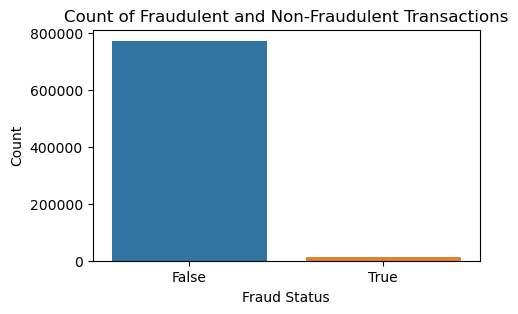

In [109]:
# Visualizing the imbalane data
plt.figure(figsize=(5, 3))
sns.countplot(x='isFraud', data=df_transactions)
plt.title('Count of Fraudulent and Non-Fraudulent Transactions')
plt.xlabel('Fraud Status')
plt.ylabel('Count')
plt.show()

In [110]:
# SMOTE method to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Checking class distribution after balancing
print("Class distribution after SMOTE:")
print(y_balanced.value_counts())

# Split dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)

# Checking the sizes of train and test sets
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Class distribution after SMOTE:
False    729029
True     729029
Name: isFraud, dtype: int64
Training set size: (1020640, 10), Test set size: (437418, 10)


In [126]:
# XGBoost model
xgb_model = XGBClassifier(
    random_state=5,  
    eta=0.1, 
    gamma=1,
    max_depth=5 
)

xgb_model.fit(X_train,y_train)

# Training accuracy
train_accuracy = xgb_model.score(X_train, y_train)
print(f"XGBoost Training Data Accuracy: {train_accuracy}")

# Predict on test data
y_test_xg = xgb_model.predict(X_test)
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]  

# Precision-recall curve
precision_xg, recall_xg, _ = precision_recall_curve(y_test, y_test_proba)

# ROC curve
fpr_xg, tpr_xg, _ = roc_curve(y_test, y_test_proba)

# ROC AUC score
roc_auc_xg = roc_auc_score(y_test, y_test_proba)

# Test performance
print("XGBoost performance:")
print(classification_report(y_test_xg, y_test))

XGBoost Training Data Accuracy: 0.8892910330772849
XGBoost performance:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89    242967
           1       0.83      0.94      0.88    194451

    accuracy                           0.89    437418
   macro avg       0.89      0.89      0.89    437418
weighted avg       0.90      0.89      0.89    437418



In [133]:
# Random Forest model
rf_model = RandomForestClassifier(
    random_state=0, 
    n_jobs = -1,
    n_estimators=100,  
    max_depth=15,       
    criterion='gini'   
)

# Fit the model
rf_model.fit(X_train, y_train)

# Training accuracy
train_accuracy = rf_model.score(X_train, y_train)
print(f"Random Forest Accuracy - Train Data: {train_accuracy}")

# Predict on test data
y_test_rf = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]  

# Precision-recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_test_proba)

# ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba)

# ROC AUC score
roc_auc_rf = roc_auc_score(y_test, y_test_proba)

# Test performance
print("Random Forest performance:")
print(classification_report(y_test_rf, y_test))


Random Forest Accuracy - Train Data: 0.8780911976798871
Random Forest performance:
              precision    recall  f1-score   support

       False       0.88      0.88      0.88    219027
        True       0.88      0.88      0.88    218391

    accuracy                           0.88    437418
   macro avg       0.88      0.88      0.88    437418
weighted avg       0.88      0.88      0.88    437418



In [128]:
# Gradient Boosting model
gb_model = GradientBoostingClassifier(
    random_state=10, 
    learning_rate=0.1,
    n_estimators=30,  
    max_depth=5,        
    subsample=0.7,      
    min_samples_split=2
)

# Fit the model
gb_model.fit(X_train, y_train)

# Training accuracy
train_accuracy = gb_model.score(X_train, y_train)
print(f"Gradient Boosting Accuracy - Train Data: {train_accuracy}")

# Predict on test data
y_test_gb = gb_model.predict(X_test)
y_test_proba = gb_model.predict_proba(X_test)[:, 1] 

# Precision-recall curve
precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_test_proba)

# ROC curve
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_test_proba)

# ROC AUC score
roc_auc_gb = roc_auc_score(y_test, y_test_proba)

# Test performance
print("Gradient Boosting performance:")
print(classification_report(y_test_gb, y_test))


Gradient Boosting Accuracy - Train Data: 0.8856756544912996
Gradient Boosting performance:
              precision    recall  f1-score   support

       False       0.92      0.86      0.89    233936
        True       0.85      0.91      0.88    203482

    accuracy                           0.89    437418
   macro avg       0.89      0.89      0.89    437418
weighted avg       0.89      0.89      0.89    437418



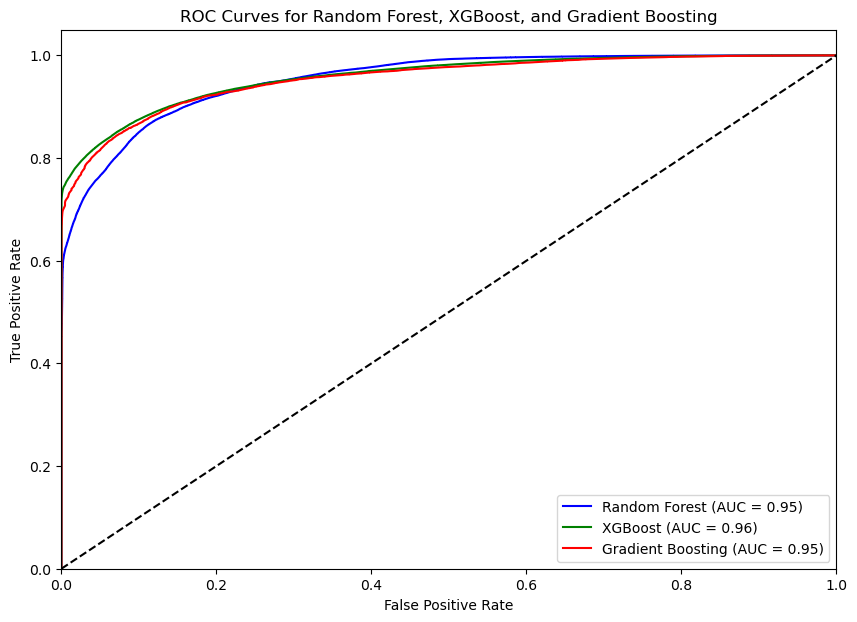

In [134]:
# Plotting the ROC curves 
plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", color='blue')
plt.plot(fpr_xg, tpr_xg, label=f"XGBoost (AUC = {roc_auc_xg:.2f})", color='green')
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {roc_auc_gb:.2f})", color='red')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest, XGBoost, and Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

The ROC curves for Random Forest, XGBoost, and Gradient Boosting show that all three models have similar performance, with AUC values close to each other (0.95-0.96). The red and green lines (XGBoost and Gradient Boosting) outperform the blue one (Random Forest).

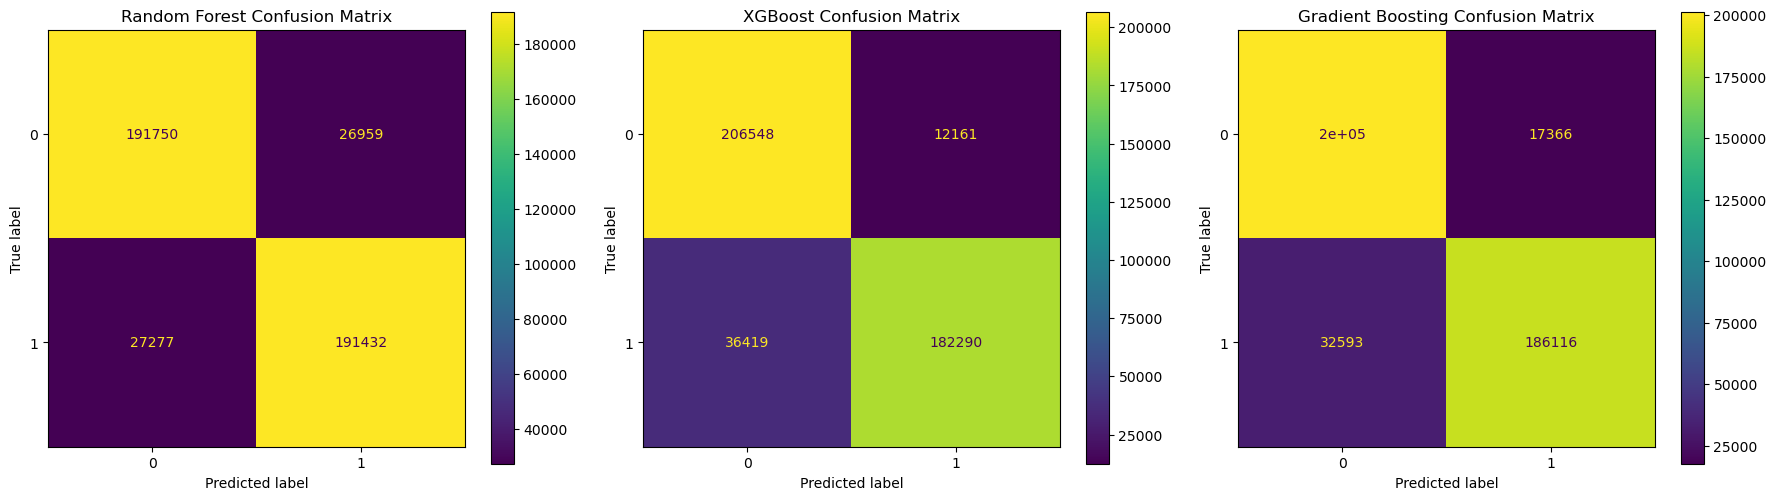

In [181]:
#### Calculate confusion matrices for each model
cm_rf = confusion_matrix(y_test, y_test_rf)
cm_xgb = confusion_matrix(y_test, y_test_xg)
cm_gb = confusion_matrix(y_test, y_test_gb)

# Plot confusion matrix for Random Forest
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay(cm_rf, display_labels=[0, 1]).plot(ax=ax[0])
ax[0].set_title('Random Forest Confusion Matrix')

ConfusionMatrixDisplay(cm_xgb, display_labels=[0, 1]).plot(ax=ax[1])
ax[1].set_title('XGBoost Confusion Matrix')

ConfusionMatrixDisplay(cm_gb, display_labels=[0, 1]).plot(ax=ax[2])
ax[2].set_title('Gradient Boosting Confusion Matrix')

plt.tight_layout()
plt.show()

When we compare the models, in terms of different metrics including Accuracy, F1- Score, ROC curve, and confusion matrices, and two of them are almost similar. But considering all the metrics, maybe XGBoost is a better model.

My mthodology explanation:
To find a good predictive model to fraud detection, since it is a binary classification problem, I selected three most popular ensemble methods. 
1. To prepare the data for their input and identify the most relevant ones, I converted some time columns to standard format. 
Also, I encoded the catogorical features.
2. I dropped obvoius unnecessary coulumns in fraud detection (like the merchant name!)
3. I did a correlation based feature selection (using pearson approach) to find the most correlated ones to the 'isFraud' column. And I chose the 10 top features.
4. I did an oversampling technique to balance the data, because it was too imbalanced.
5. I feeded the prepared data to the classifiers and then compare them using different metrics to catch the important the details about their performance.
